In [64]:
#Copyright © 2022 Susancutie. All rights reserved.
#波士顿房价预测
#下面的代码中我利用包括线性模型、GradientBoosting（梯度提升）、Lasso 回归、ElasticNet 回归、SVM（支持向量机）回归等各种回归模型对波士顿房价进行了预测并给出了模型评估
#对任务的说明与最后的总结均在各个代码块的注释中
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
plt.style.use('ggplot')
%load_ext klab-autotime

The klab-autotime extension is already loaded. To reload it, use:
  %reload_ext klab-autotime
time: 1.46 ms


In [65]:
#sklearn库中就有波士顿房屋数据集，可以直接读取数据集
#出现了FutureWarning警示，通过查阅资料得知该数据集在sklearn的未来版本将会被移除，但当前版本可用
from sklearn.datasets import load_boston
dir(load_boston())
print(load_boston().DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/opt/python/envs/default/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

In [66]:
#X为特征对应的数据，y为待预测的波士顿房价。使用 Pandas 的 DataFrame 数据结构存储数据
X = load_boston().data
y = load_boston().target
df = pd.DataFrame(X, columns=load_boston().feature_names)
df['MEDV'] = y
#打印出DataFrame的前几行
df.head()

time: 32.7 ms


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


time: 1.14 s


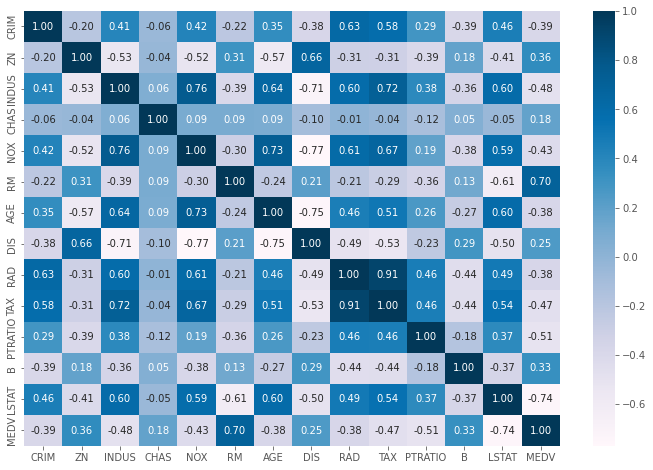

In [67]:
#打印出热力图，看看各个特征和待预测的房价之间是否有相关性，判断一下用哪种模型比较合适
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='PuBu')
#通过观察热力图，数据不存在相关性较小的属性，也不用担心共线性，所以可以用线性回归模型去预测

time: 3.39 s


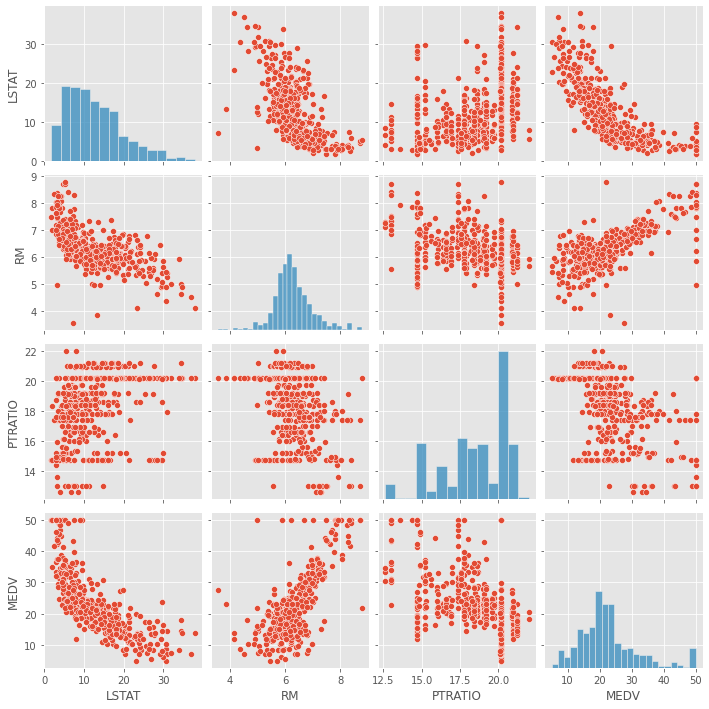

In [68]:
#进行多变量研究，尝试了解因变量和自变量、自变量和自变量之间的关系
sns.pairplot(df[["LSTAT","RM","PTRATIO","MEDV"]])

In [69]:
#打印出各项特征和待预测值的相关性
df.corr()['MEDV'].sort_values()

time: 5.06 ms


In [70]:
#把待预测的波士顿房价那一列数据移除
df.drop(columns=['MEDV'],inplace=True)
df.head()

time: 19.6 ms


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [71]:
# 划分训练集和测试集，20%作为测试集，80%作为训练集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888)

time: 2.15 ms


In [72]:
#建立线性回归模型进行预测，并对模型进行评估，其中SCORE为模型得分，RMSE为均方误差
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
coef = linear_model.coef_#回归系数
line_pre = linear_model.predict(X_test)
print('SCORE:{:.4f}'.format(linear_model.score(X_test, y_test)))
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test, line_pre))))
coef  #打印回归系数

SCORE:0.7559
RMSE:4.3708
time: 7.04 ms


In [73]:
df_coef = pd.DataFrame()
df_coef['Title'] = df.columns
df_coef['Coef'] = coef
df_coef

time: 8.73 ms


,Title,Coef
0,CRIM,-0.119007
1,ZN,0.036406
2,INDUS,0.016855
3,CHAS,2.293970
4,NOX,-16.070645
5,RM,3.723715
6,AGE,0.009228
7,DIS,-1.306748
8,RAD,0.343073
9,TAX,-0.014583


time: 247 ms


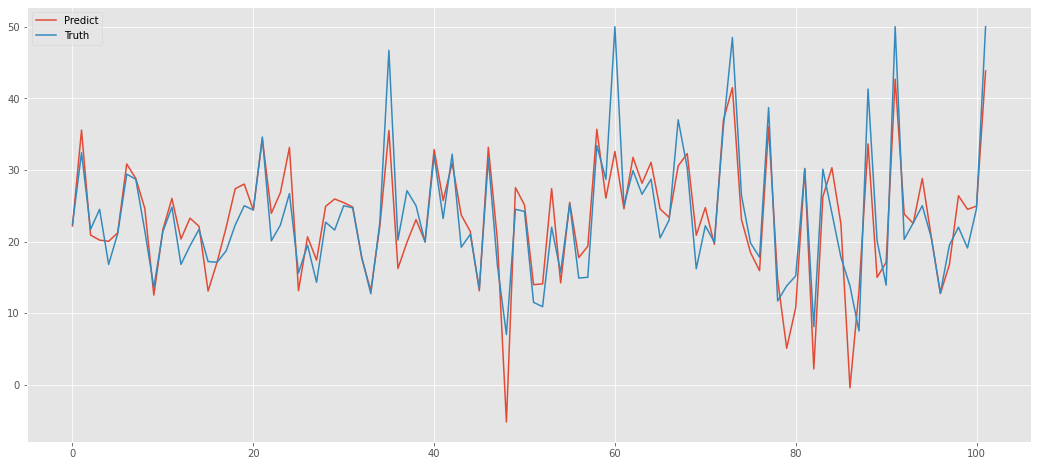

In [74]:
#下面进行可视化，可以直观地看出模型预测值和真值之间的差别
#从下图可以看出在70-100区间预测的房价偏小，在0-10、38-47区间预测较准，多数区间预测值偏大。可进一步对原始数据离群值做处理。
hos_pre = pd.DataFrame()
hos_pre['Predict'] = line_pre
hos_pre['Truth'] = y_test
hos_pre.plot(figsize=(18,8))

time: 153 ms


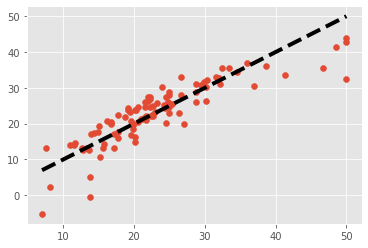

In [75]:
plt.scatter(y_test, line_pre,label='y')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4,label='predicted')

SCORE:0.7388
RMSE:4.6959
time: 262 ms


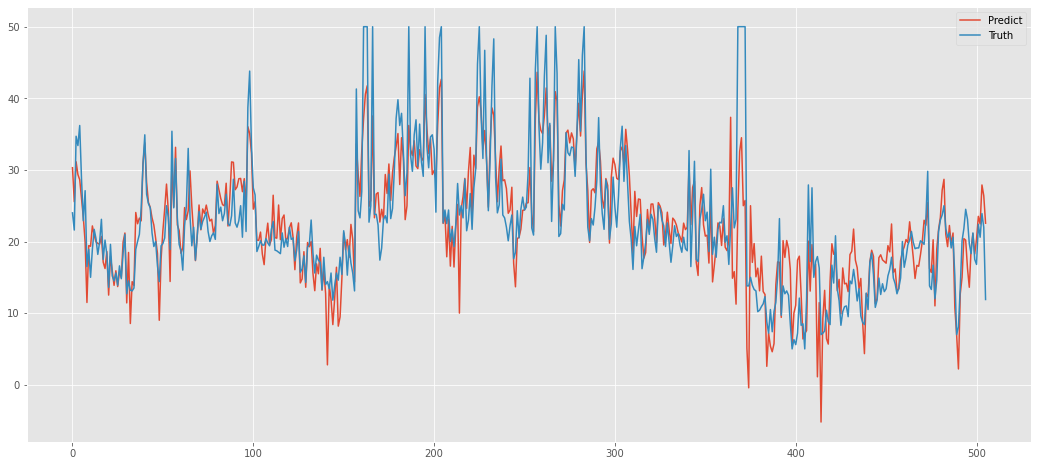

In [76]:
#在整个数据集中评价模型
line_pre_all = linear_model.predict(X)  #预测值
print('SCORE:{:.4f}'.format(linear_model.score(X,y)))
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y, line_pre_all))))
hos_pre_all = pd.DataFrame()
hos_pre_all['Predict'] = line_pre_all
hos_pre_all['Truth'] = y
hos_pre_all.plot(figsize=(18,8))

time: 152 ms


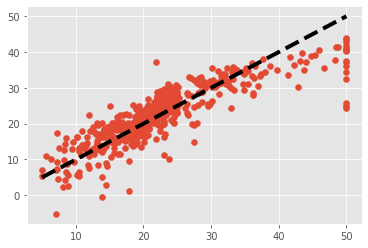

In [77]:
plt.scatter(y, line_pre_all,label='y')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4,label='predicted')

In [78]:
#由以上分析可知，模型在整个数据集中的评分比在测试集中要低

time: 279 µs


In [79]:
#进一步探索和模型改进
#1.尝试使用相关性最高的3个特征量重建模型，并与原模型进行比较
#2.尝试使用其它多种算法分别建立模型，并比较模型

time: 316 µs


In [80]:
X2 = np.array(df[['LSTAT','RM','PTRATIO']])
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, random_state=1,test_size=0.2)
linear_model2 = LinearRegression()
linear_model2.fit(X2_train,y_train)
print(linear_model2.intercept_)
print(linear_model2.coef_)
line2_pre = linear_model2.predict(X2_test)  #预测值
print('SCORE:{:.4f}'.format(linear_model2.score(X2_test, y_test)))#模型评分
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test, line2_pre))))#RMSE(标准误差)

24.112838451644933
[-0.59061956  3.81700007 -0.97465491]
SCORE:0.6959
RMSE:5.4820
time: 6.16 ms


In [81]:
line2_pre_all = linear_model2.predict(X2)  #预测值
print('SCORE:{:.4f}'.format(linear_model2.score(X2, y)))#模型评分
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y, line2_pre_all))))#RMSE(标准误差)

SCORE:0.6766
RMSE:5.2254
time: 2.78 ms


In [82]:
#可以看出，使用相关性最高的3个特征量重建的模型得分反而不如使用所有特征量的模型高

time: 317 µs


In [83]:
#数据集的标准化对scikit-learn中实现的大多数机器学习算法来说是常见的要求 。
#如果个别特征或多或少看起来不是很像标准正态分布(具有零均值和单位方差)，那么它们的表现力可能会较差。
#下面进行数据标准化处理
from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
X_train = ss_x.fit_transform(X_train)
X_test = ss_x.transform(X_test)
ss_y = StandardScaler()
y_train = ss_y.fit_transform(y_train.reshape(-1, 1))
y_test = ss_y.transform(y_test.reshape(-1, 1))

time: 3.57 ms


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

time: 1.53 ms


In [85]:
#下面会尝试各种其他模型对波士顿房价进行预测，并给出对模型的评估

time: 306 µs


In [86]:
# GradientBoosting（梯度提升）
from sklearn import ensemble
#params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,'learning_rate': 0.01, 'loss': 'ls'}
#clf = ensemble.GradientBoostingRegressor(**params)
clf = ensemble.GradientBoostingRegressor()
clf.fit(X_train, y_train)
clf_pre=clf.predict(X_test) #预测值
print('SCORE:{:.4f}'.format(clf.score(X_test, y_test)))#模型评分
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test, clf_pre))))#RMSE(标准误差)

SCORE:0.8957
RMSE:3.2486
time: 118 ms


In [87]:
# Lasso 回归 （Least Absolute Shrinkage and Selection Operator）
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score as r2

lasso = Lasso()
lasso.fit(X_train,y_train)
y_predict_lasso = lasso.predict(X_test)
r2_score_lasso = r2(y_test,y_predict_lasso)

print('SCORE:{:.4f}'.format( lasso.score(X_test, y_test)))#模型评分
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test,y_predict_lasso))))#RMSE(标准误差)
print('Lasso模型的R-squared值为:',r2_score_lasso)

SCORE:0.6799
RMSE:5.6914
Lasso模型的R-squared值为: 0.6798796125211477
time: 4.67 ms


In [88]:
# ElasticNet 回归
from sklearn.linear_model import ElasticNet
enet = ElasticNet()
enet.fit(X_train,y_train)
y_predict_enet = enet.predict(X_test)
r2_score_enet = r2(y_test,y_predict_enet)

print('SCORE:{:.4f}'.format( enet.score(X_test, y_test)))#模型评分
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test,y_predict_enet))))#RMSE(标准误差)
print("ElasticNet模型的R-squared值为:",r2_score_enet)

SCORE:0.6874
RMSE:5.6242
ElasticNet模型的R-squared值为: 0.6873956939055255
time: 4.36 ms


In [89]:
# Support Vector Regression (SVR)
from sklearn.svm import SVR
from sklearn.metrics import r2_score as r2, mean_squared_error as mse, mean_absolute_error as mae

def svr_model(kernel):
    svr = SVR(kernel=kernel) 
    svr.fit(X_train, y_train)
    y_predict = svr.predict(X_test)

    # score(): Returns the coefficient of determination R^2 of the prediction.
    print(kernel,' SVR的默认衡量评估值值为：', svr.score(X_test,y_test))
    print(kernel,' SVR的R-squared值为：', r2(y_test, y_predict))
    print(kernel,' SVR的均方误差（mean squared error）为：',mse(y_test, y_predict))
    print(kernel,' SVR的平均绝对误差（mean absolute error）为：',mae(y_test,y_predict))
    # print(kernel,' SVR的均方误差（mean squared error）为：',mse(scalery.inverse_transform(y_test), scalery.inverse_transform(y_predict)))
    # print(kernel,' SVR的平均绝对误差（mean absolute error）为：',mae(scalery.inverse_transform(y_test),scalery.inverse_transform(y_predict)))
    
    return svr

time: 824 µs


In [90]:
#linear 线性核函数
linear_svr = svr_model(kernel='linear') 

linear  SVR的默认衡量评估值值为： 0.7119702464385773
linear  SVR的R-squared值为： 0.7119702464385773
linear  SVR的均方误差（mean squared error）为： 29.14485593202565
linear  SVR的平均绝对误差（mean absolute error）为： 3.4799852264204376
time: 1.77 s


In [91]:
#poly 多项式核
poly_svr = svr_model(kernel='poly')  

poly  SVR的默认衡量评估值值为： 0.20185510417915498
poly  SVR的R-squared值为： 0.20185510417915498
poly  SVR的均方误差（mean squared error）为： 80.76185780792792
poly  SVR的平均绝对误差（mean absolute error）为： 5.813046161039349
time: 15.7 ms


In [92]:
#rbf（Radial Basis Function） 径向基函数
rbf_svr = svr_model(kernel='rbf') 

rbf  SVR的默认衡量评估值值为： 0.23368969054695043
rbf  SVR的R-squared值为： 0.23368969054695043
rbf  SVR的均方误差（mean squared error）为： 77.54061270434813
rbf  SVR的平均绝对误差（mean absolute error）为： 5.723785340822044
time: 20.6 ms


In [93]:
# SVM（支持向量机）回归-- 线性核
from sklearn.svm import SVR
linear_svr = SVR(kernel="linear")
linear_svr.fit(X_train, y_train.ravel())
linear_svr_pre = linear_svr.predict(X_test)#预测值
print('SCORE:{:.4f}'.format(linear_svr.score(X_test, y_test)))#模型评分
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test, linear_svr_pre))))#RMSE(标准误差)

SCORE:0.7120
RMSE:5.3986
time: 1.78 s


In [94]:
# SVM（支持向量机）回归-- 多项式核
from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler() 
X_train = ss_x.fit_transform(X_train) 
X_test = ss_x.transform(X_test) 
ss_y = StandardScaler() 
y_train = ss_y.fit_transform(y_train.reshape(-1, 1)) 
y_test = ss_y.transform(y_test.reshape(-1, 1))

time: 3.35 ms


In [95]:
poly_svr = SVR(kernel="poly") 
poly_svr.fit(X_train, y_train.ravel()) 
poly_svr_pre = poly_svr.predict(X_test)#预测值 
print('SCORE:{:.4f}'.format(poly_svr.score(X_test, y_test)))#模型评分 
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test, poly_svr_pre))))#RMSE(标准误差)

SCORE:0.8504
RMSE:0.4345
time: 20.2 ms


In [96]:
#归纳总结
#利用GradientBoosting（梯度提升）的得分接近90，这是目前为止最优的一个模型，其次就是SVM回归的多项式核模型，也大概达到了85，
#其他的模型并没有线性回归那么优，所以对于波士顿房价预测来说，利用GradientBoosting（梯度提升）是最好的

time: 313 µs
